# File Selection

This notebook servesa to select the documents from the Lusa dataset that will be used to select the best prompts templates for each model.

The idea is to select 20 documents to evaluate the prompt templates the were developed. Since the sample size is small, one needs to be carefull in the sampling process. The goal is to have a sample that produces a good estimate of the expected effectivness of the templates on the full corpus.

Since the templates will be used to extract events, participants, time expressions, and their respective classes, there is no trivial way to select the set of documents for the sample. Ideally, we would like to have a documents to be diverse in complexity of annotation which, by itself, its hard to define. In this research we asssume that the complexity of annotation is approximated by the number of tokens in a given document. This seems a reseunable assumption as the number of entities (most often) increases with the number of tokens in the document.

Given this definition of complexity we defined the sampling process as follows. 

    - 1. all documents were sorted by the number of tokens. 
    - 2. Then the dataset was devide in 20 quantiles (also know as vintiles), which is the number of documents we want to sample.
    - 3. Finally, we randomly sample one document from each quantile.

By following this procedure we ensure that the sample to select the templates prompts to be employed in the full evaluation are representative of the entire corpus.

This procedure basically ensures that the sample we get is truly uniform over the observed data.

In [8]:
from pathlib import Path

import matplotlib.ticker as mtick

from src.reader import read_lusa

ROOT = Path().resolve().parent
DATA_PATH = ROOT / "resources" / "lusa"

N_DOCS = 20

In [9]:
lusa = read_lusa(DATA_PATH)

In [10]:
event_classes = set(event.class_ for doc in lusa for event in doc.events if hasattr(event, "class_"))
print("Event classes:", event_classes)

participant_classes = set(participant.participant_type_domain for doc in lusa for participant in doc.participants if hasattr(participant, "participant_type_domain"))
print("Participant classes:", participant_classes)

timexs_classes = set(timex.time_type for doc in lusa for timex in doc.timexs if hasattr(timex, "time_type"))
print("Timex classes:", timexs_classes)

Event classes: {'Reporting', 'State', 'I_State', 'Occurrence', 'Aspectual', 'Perception', 'I_Action'}
Participant classes: {'Loc', 'Per', 'Fac', 'Obj', 'Org', 'Nat', 'Other'}
Timex classes: {'Time', 'Date', 'Set', 'Duration'}


## Document Sampling

In [11]:
from nltk import word_tokenize

n_tkns_docs = [(len(word_tokenize(doc.text)), doc) for doc in lusa]
sorted_docs = sorted(n_tkns_docs, key=lambda x: x[0], reverse=True)
n_tkns, docs = zip(*sorted_docs)

In [12]:
import numpy as np

n_tkns = np.array(n_tkns)
docs = np.array(docs)

percentiles = np.linspace(0, 1, (N_DOCS + 1))
quantiles = np.quantile(n_tkns, percentiles)

In [13]:
np.random.seed(42)

sampled_docs = []
windows = zip(quantiles[:-1], quantiles[1:])
for start, end in windows:
    mask = (start <= n_tkns) & (n_tkns < end)
    perecentile_docs = docs[mask]
    [doc] = np.random.choice(perecentile_docs, 1)
    sampled_docs.append(doc)

sampled_docs

[Document(id=lusa_190),
 Document(id=lusa_101),
 Document(id=lusa_178),
 Document(id=lusa_186),
 Document(id=lusa_161),
 Document(id=lusa_177),
 Document(id=lusa_15),
 Document(id=lusa_174),
 Document(id=lusa_166),
 Document(id=lusa_13),
 Document(id=lusa_143),
 Document(id=lusa_106),
 Document(id=lusa_189),
 Document(id=lusa_168),
 Document(id=lusa_157),
 Document(id=lusa_192),
 Document(id=lusa_171),
 Document(id=lusa_100),
 Document(id=lusa_11),
 Document(id=lusa_199)]

## Documents Analysis

In [14]:
from collections import Counter

def compute_statistics(documents: list) -> dict:
    statistics = {
        "events": {"counts": [] ,"classes": []},
        "participants": {"counts": [] ,"classes": []},
        "timexs": {"counts": [] ,"classes": []},
    }
    for doc in documents:
        n_events = len(doc.events)
        c_events = {c: 0 for c in event_classes}
        for event in doc.events:
            if hasattr(event, "class_"):
                c_events[event.class_] += 1
        statistics["events"]["counts"].append(n_events)
        statistics["events"]["classes"].append(c_events)

        n_participants = len(doc.participants)
        c_participants = {c: 0 for c in participant_classes}
        for participant in doc.participants:
            if hasattr(participant, "participant_type_domain"):
                c_participants[participant.participant_type_domain] += 1
        statistics["participants"]["counts"].append(n_participants)
        statistics["participants"]["classes"].append(c_participants)

        n_timexs = len(doc.timexs)
        c_timexs = {c: 0 for c in timexs_classes}
        for timex in doc.timexs:
            if hasattr(timex, "time_type"):
                c_timexs[timex.time_type] += 1
        statistics["timexs"]["counts"].append(n_timexs)
        statistics["timexs"]["classes"].append(c_timexs)
    return statistics

In [15]:
lusa_stats = compute_statistics(lusa)
sampled_docs_stats = compute_statistics(sampled_docs)

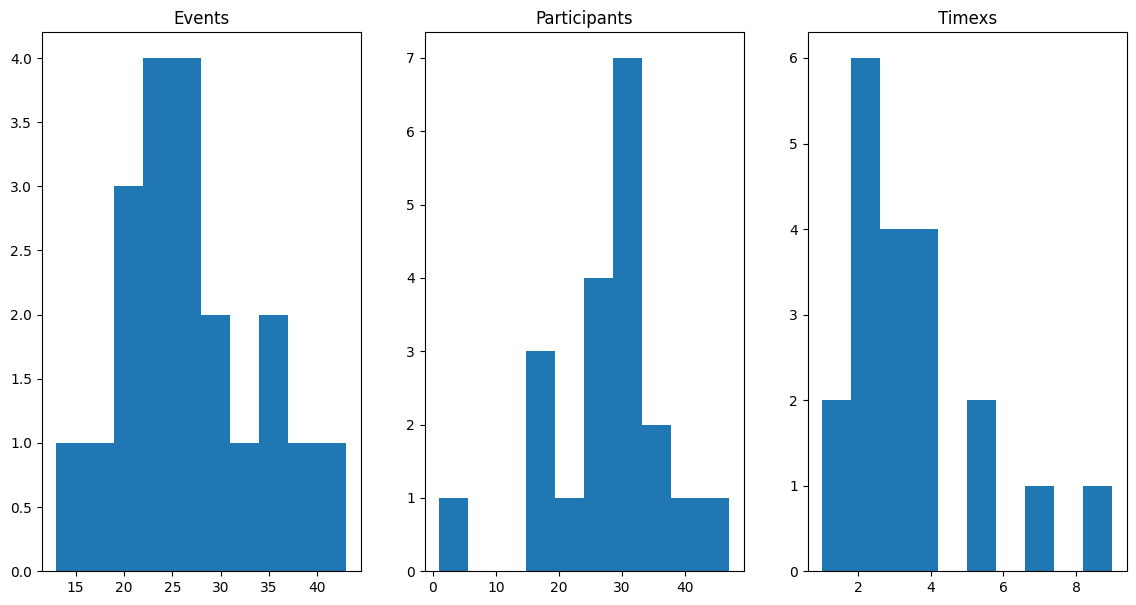

In [16]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 7))
plt.subplot(1, 3, 1)
plt.hist(sampled_docs_stats["events"]["counts"])
plt.title("Events")
plt.subplot(1, 3, 2)
plt.hist(sampled_docs_stats["participants"]["counts"])
plt.title("Participants")
plt.subplot(1, 3, 3)
plt.hist(sampled_docs_stats["timexs"]["counts"])
plt.title("Timexs")
plt.show()

In [17]:
def plot_stacked_bar(classes, classes_stats):
    running_count = {c: 0 for c in classes}
    for class_ in classes_stats:
        plt.bar(class_.keys(), class_.values(), bottom=list(running_count.values()))
        for c in classes:
            running_count[c] += class_.get(c, 0)

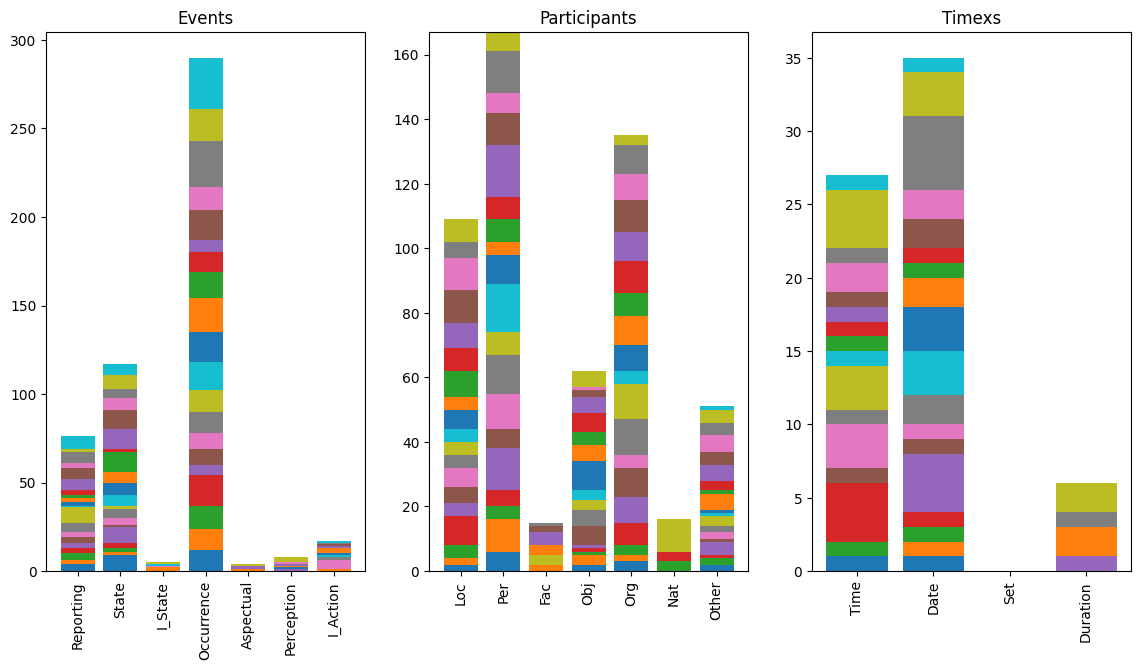

In [18]:
plt.figure(figsize=(14, 7))

plt.subplot(1, 3, 1)
plot_stacked_bar(event_classes, sampled_docs_stats["events"]["classes"])
plt.xticks(rotation=90)
plt.title("Events")

plt.subplot(1, 3, 2)
plot_stacked_bar(participant_classes, sampled_docs_stats["participants"]["classes"])
plt.xticks(rotation=90)
plt.title("Participants")

plt.subplot(1, 3, 3)
plot_stacked_bar(timexs_classes, sampled_docs_stats["timexs"]["classes"])
plt.xticks(rotation=90)
plt.title("Timexs")

plt.show()


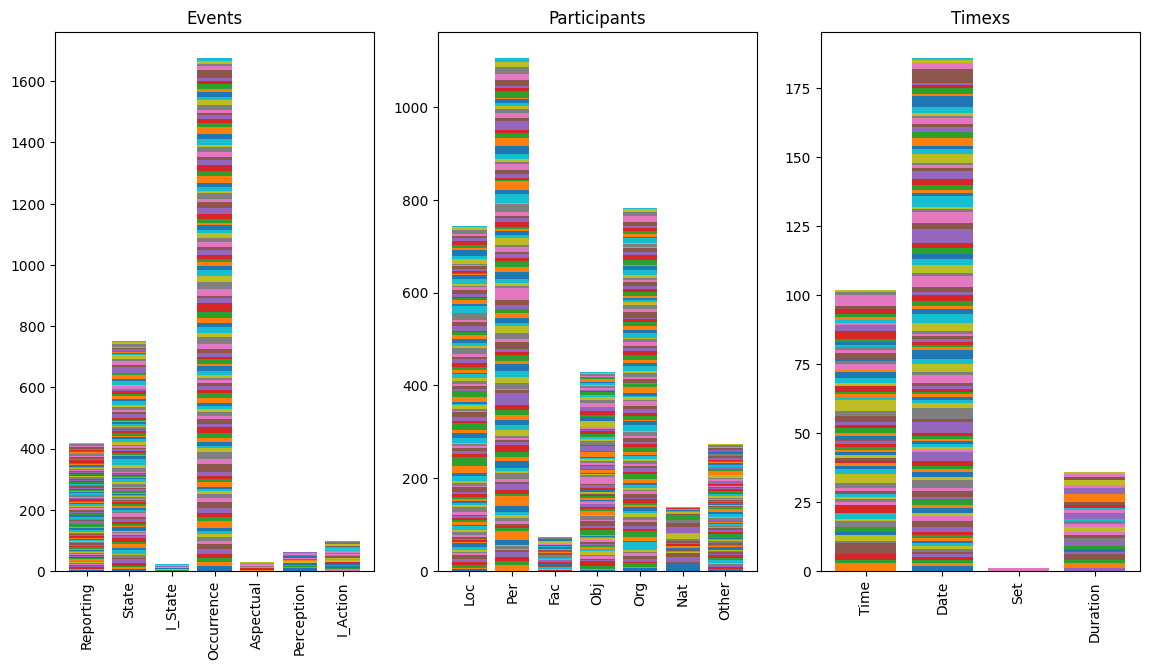

In [19]:
plt.figure(figsize=(14, 7))

plt.subplot(1, 3, 1)
plot_stacked_bar(event_classes, lusa_stats["events"]["classes"])
plt.xticks(rotation=90)
plt.title("Events")

plt.subplot(1, 3, 2)
plot_stacked_bar(participant_classes, lusa_stats["participants"]["classes"])
plt.xticks(rotation=90)
plt.title("Participants")

plt.subplot(1, 3, 3)
plot_stacked_bar(timexs_classes, lusa_stats["timexs"]["classes"])
plt.xticks(rotation=90)
plt.title("Timexs")

plt.show()


In [20]:
lusa_class_counts = {
    "events": Counter([event.class_ for doc in lusa for event in doc.events if hasattr(event, "class_")]),
    "participants": Counter([participant.participant_type_domain for doc in lusa for participant in doc.participants if hasattr(participant, "participant_type_domain")]),
    "timexs": Counter([timex.time_type for doc in lusa for timex in doc.timexs if hasattr(timex, "time_type")]),
}

sample_class_counts = {
    "events": Counter([event.class_ for doc in sampled_docs for event in doc.events if hasattr(event, "class_")]),
    "participants": Counter([participant.participant_type_domain for doc in sampled_docs for participant in doc.participants if hasattr(participant, "participant_type_domain")]),
    "timexs": Counter([timex.time_type for doc in sampled_docs for timex in doc.timexs if hasattr(timex, "time_type")]),
}

In [21]:
class_map = {
    "I_Action": "I. Action",
    'I_State': "I. State",
    'Obj': "Object",
    'Per': "Person",
    'Loc': "Location",
    'Org': "Organization",
    'Fac': "Facility",
    'Nat': "Nature"
}

In [22]:
lusa_class_perc = {}
for entity, classes in lusa_class_counts.items():
    total = sum(classes.values())
    prec = {class_map.get(c, c): v / total * 100 for c, v in classes.items()}
    lusa_class_perc[entity] = prec


sample_class_perc = {}
for entity, classes in sample_class_counts.items():
    total = sum(classes.values())
    prec = {class_map.get(c, c): v / total * 100 for c, v in classes.items()}
    sample_class_perc[entity] = prec

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


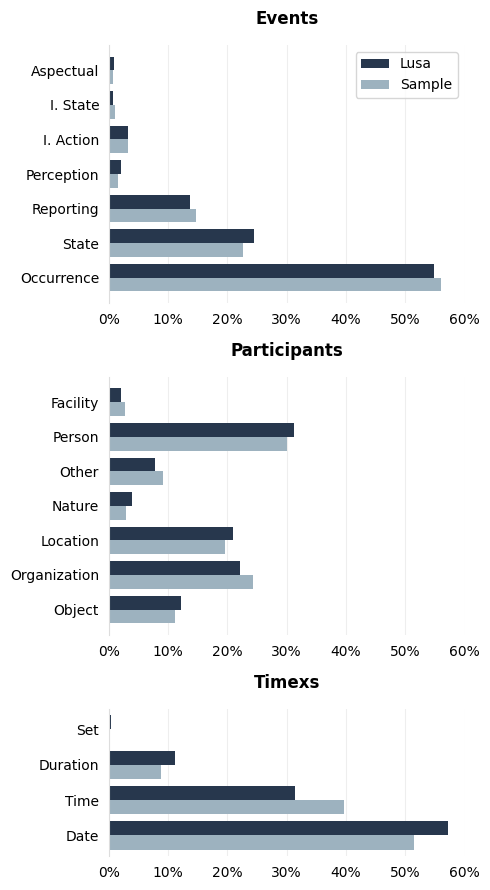

In [23]:
entities = ["events", "participants", "timexs"]

first = True
fig, axs = plt.subplots(3, 1, layout='tight', figsize=(5, 9), height_ratios=[7, 7, 4])
for entity, ax in zip(entities, axs.flatten()):
    classes = list(lusa_class_perc[entity].keys())

    y = np.arange(len(classes))

    width = 0.4

    b1 = ax.barh(y + width, [lusa_class_perc[entity].get(c, 0)
                 for c in classes], width, label='Lusa', color='#27374D')
    b2 = ax.barh(y, [sample_class_perc[entity].get(c, 0)
                 for c in classes], width, label='Sample', color='#9DB2BF')

    ax.set_xlim(0, 60)
    ax.set_yticks(y + width / 2)
    ax.set_yticklabels(classes)
    ax.xaxis.set_major_formatter(mtick.PercentFormatter())

    ax.set_title(entity.capitalize(), pad=15, weight='bold', size=12)
    if first:
        ax.legend(loc='upper right')
        first = False

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_color('#DDDDDD')
    ax.spines['bottom'].set_visible(False)
    ax.tick_params(bottom=False, left=False)
    ax.set_axisbelow(True)
    ax.xaxis.grid(True, color='#EEEEEE')
    ax.yaxis.grid(False)

#plt.savefig('sample.jpg', dpi=300)
plt.savefig('sample.eps', format='eps', dpi=1200)
plt.show()

In [ ]:
    [event.class_ for doc in lusa for event in doc.events if hasattr(event, "class_")]
    [participant.participant_type_domain for doc in lusa for participant in doc.participants if hasattr(participant, "participant_type_domain")]
    [timex.time_type for doc in lusa for timex in doc.timexs if hasattr(timex, "time_type")]

In [24]:
for event in doc.events:
     if hasattr(event, "class_"):
            print(event.class_, event.text)

Occurrence sofreu
Occurrence acidente
Occurrence que
Occurrence derrubou
Reporting disse
Occurrence derrubado
Occurrence atingindo
State circulava
Occurrence transportada
State com vida
Occurrence acabou por morrer
Occurrence atingiu
Occurrence sofreu
State ferimentos ligeiros
Occurrence acidente
Occurrence ocorreu
Reporting esclareceu
Occurrence acidente
Occurrence provocou
Occurrence queda
State envolveu
I_Action decidiu
Occurrence terá acontecido
Occurrence ordenou
Occurrence abertura
Occurrence processo
Occurrence averiguação interna
State estando também, naturalmente, disponível
Occurrence colaborar
Reporting assinala
Reporting lamentando
Occurrence morte
Reporting endereçando
Occurrence morreu
Occurrence derrubou
Occurrence matou
State ferimentos ligeiros
Occurrence que
Occurrence averiguar
Occurrence causas
Occurrence acidente
Reporting comunicado
Reporting acordo
